# GMM Approach to mean/variability 

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp

In [2]:
import numpy as np
from scipy.special import psi
from statsmodels.sandbox.regression.gmm import GMM

### Simulate some linear data

In [3]:
beta1 = np.array([5, 3]).reshape(2, -1)
beta2 = np.array([0.1, 0.2]).reshape(2, -1)
x = np.arange(0, 10, 0.001)
x = np.column_stack([np.ones(x.shape[0]), x])
y = (x@beta1).reshape(-1) + stats.norm.rvs(loc=0, scale=np.sqrt((x@beta2).reshape(-1)))
y = y.reshape(-1, 1)

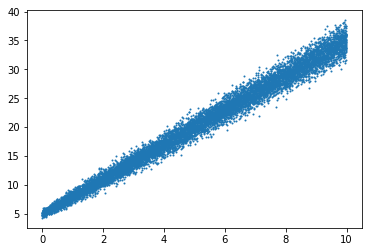

In [4]:
plt.scatter(x[:, -1], y, s=1)

In [5]:
residual = y-x@beta1

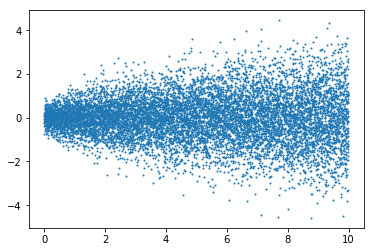

In [6]:
plt.scatter(x[:, -1], (y-x@beta1), s=1)

In [7]:
def moment_condition_linear(beta_hat):
    
    beta1_hat, beta2_hat = beta_hat[:int(beta_hat.shape[0]/2)], beta_hat[int(beta_hat.shape[0]/2):]
    residual_1 = y-x@(beta1_hat.reshape(2, -1))
    residual_mat_1 = np.tile(residual_1, (1, 2))
    error_1 = (x*residual_mat_1).mean(axis=0)
    
    residual_2 = (residual_1)**2 - x@(beta2_hat.reshape(2, -1))
    residual_mat_2 = np.tile(residual_2, (1, 2))
    error_2 = (x*residual_mat_2).mean(axis=0)
    
    return (error_2**2).sum() + (error_2**2).sum()


    #return (error_1**2).sum()
    

In [8]:
result = sp.optimize.minimize(moment_condition_linear, np.concatenate([beta1, beta2]))

In [9]:
result

      fun: 3.732174440413189e-11
 hess_inv: array([[ 1.00151768,  0.0084406 ,  0.06757342, -0.00969847],
       [ 0.0084406 ,  1.04687479,  0.37705622, -0.04719541],
       [ 0.06757342,  0.37705622,  3.97890646, -0.59942715],
       [-0.00969847, -0.04719541, -0.59942715,  0.09061657]])
      jac: array([9.29766943e-08, 6.76257609e-07, 3.14971563e-07, 2.57146924e-06])
  message: 'Optimization terminated successfully.'
     nfev: 42
      nit: 5
     njev: 7
   status: 0
  success: True
        x: array([4.99995579, 2.99972785, 0.0986448 , 0.20368808])

### Simulate some nonlinear data - only mean

Poisson noise process

In [10]:
def convert_params(mu, theta):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    r = theta
    var = mu + 1 / r * mu ** 2
    p = (var - mu) / var
    return r, 1 - p

In [11]:
num_rep = 1000
x = np.arange(0, 4, 1)
x_mat = np.column_stack([np.ones(x.shape[0]), x])
beta0 = 2
beta1 = 0.8
mean = np.exp(beta0 + beta1*x)
theta = 10*np.ones(mean.shape)
y_poi = stats.poisson.rvs(mean, size=(num_rep, x.shape[0]))
y = stats.nbinom.rvs(*convert_params(mean, theta), size=(num_rep, x.shape[0]))
x = np.tile(x, (1, num_rep)).reshape(-1)
y = y.reshape(-1)
y_poi = y_poi.reshape(-1)


x_mat = np.column_stack([np.ones(x.shape[0]), x])

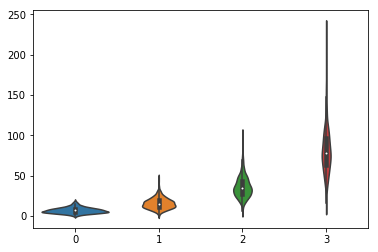

In [12]:
#sns.violinplot(pd.Series(np.concatenate([x, x+0.5])), np.concatenate([y, y_poi]))
sns.violinplot(pd.Series(x), y)

In [35]:
def moment_condition_loglinear(beta_hat):
    
    residual = y.reshape(-1, 1)-np.exp(x_mat@beta_hat.reshape(2, -1))
    residual_mat = np.tile(residual, (1, 2))
    error = (x_mat*residual_mat).mean(axis=0)
    #print(error)
    return (error**2)#.sum()
    

In [36]:
class GMMLogLinear(GMM):

    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 2)
        kwds.setdefault('k_params', 2)
        super(GMMLogLinear, self).__init__(*args, **kwds)


    def momcond(self, params):
        
        y = self.endog
        x = self.exog

        residual = y.reshape(-1, 1)-np.exp(x@params.reshape(2, -1))
        residual_mat = np.tile(residual, (1, 2))
        error = x_mat*residual_mat
        #print(error.shape)
        
        return error

In [37]:
%%time
init = np.ones(2)*(np.log(y+1).mean()/2)


model = GMMLogLinear(y, x_mat, None)
res = model.fit(init, maxiter=2, optim_method='nm', wargs=dict(centered=False))
print(res.summary())

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 45
         Function evaluations: 88
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 24
         Function evaluations: 48
                             GMMLogLinear Results                             
Dep. Variable:                      y   Hansen J:                    8.496e-06
Model:                   GMMLogLinear   Prob (Hansen J):                   nan
Method:                           GMM                                         
Date:                Mon, 24 Feb 2020                                         
Time:                        17:07:49                                         
No. Observations:                4000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        

In [38]:
%%time
result = sp.optimize.minimize(
    moment_condition_loglinear, 
    np.array([0, 0]),
    method='Nelder-Mead')

ValueError: setting an array element with a sequence.

In [39]:
%%time
result = sp.optimize.fsolve(
    moment_condition_loglinear, 
    np.array([0, 0]))

CPU times: user 12.3 ms, sys: 3.83 ms, total: 16.2 ms
Wall time: 15.4 ms


In [40]:
result

array([1.96761222, 0.81054025])

### Simulate some data with varying dispersion

In [3]:
def convert_params(mu, theta):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    r = theta
    var = mu + 1 / r * mu ** 2
    p = (var - mu) / var
    return r, 1 - p

In [52]:
num_rep = 2000
x = np.arange(0, 3, 1)
x = np.tile(x, (1, num_rep)).reshape(-1)
x_mat = np.column_stack([np.ones(x.shape[0]), x])
beta1 = np.array([1, 1])
beta2 = np.array([1, -0.1])
p = 1
mean = np.exp(x_mat@beta1)
alpha = np.exp(x_mat@beta2)
var = alpha * (mean**p)
y = stats.nbinom.rvs(*convert_params(mean, 1/((var-mean)/mean**2)))
y = y.reshape(-1)

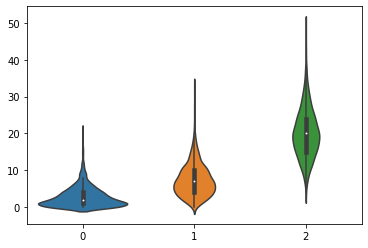

In [53]:
sns.violinplot(pd.Series(x), y)

In [54]:
df = pd.DataFrame()
df['intercept'] = np.ones(x.shape[0])
df['x'] = x
df['y'] = y
df = df.groupby(df.columns.tolist(), as_index=False).size().reset_index(name='count')

In [56]:
df.shape

(92, 4)

In [93]:
def deconstruct_params(params):
    
    beta1 = params[:2]
    beta2 = params[2:4]
    #p_hat = params[-1]
    
    return beta1, beta2

In [94]:
y = df['y'].values.reshape(-1, 1)
x_mat = df[['intercept', 'x']].values
weights = df['count'].values.reshape(-1, 1)

In [95]:
def moment_condition_loglinear(params):
    
    beta1_hat, beta2_hat = deconstruct_params(params)
    
    # 1st moment
    residual1 = y - np.exp(x_mat@beta1_hat.reshape(2, -1))
    residual_mat_1 = np.tile(residual1, (1, 2))
    error_1 = ((x_mat*residual_mat_1)*weights).mean(axis=0)
    
#     # Variance
#     residual2 = (residual1**2) - (np.exp(x_mat@beta1_hat.reshape(2, -1))*np.exp(x_mat@beta2_hat.reshape(2, -1)))
#     residual_mat_2 = np.tile(residual2, (1, 2))
#     error_2 = (x_mat*residual_mat_2).mean(axis=0)
    
    return error_1 #np.concatenate([error_1, error_2])
    

In [118]:
%%time
init = np.ones(2)*(np.log(y+1).mean()/2)
print(init.shape)
#init = np.concatenate([beta1, beta2])
# result_1 = sp.optimize.fsolve(
#     moment_condition_loglinear, 
#     init)
result_2 = sp.optimize.root(
    moment_condition_loglinear, 
    beta1)
print(result_2)

(2,)
    fjac: array([[-0.53608504, -0.84416398],
       [ 0.84416398, -0.53608504]])
     fun: array([-2.21712503e-12, -9.13989657e-12])
 message: 'The solution converged.'
    nfev: 7
     qtf: array([7.96806246e-09, 2.79835277e-09])
       r: array([1224.97180416, 2163.68092222,  149.93280074])
  status: 1
 success: True
       x: array([1.00646449, 0.99591752])
CPU times: user 4.07 ms, sys: 0 ns, total: 4.07 ms
Wall time: 3.45 ms


In [119]:
%%time
init = np.ones(2)*(np.log(y+1).mean()/2)
print(init.shape)
#init = np.concatenate([beta1, beta2])
# result_1 = sp.optimize.fsolve(
#     moment_condition_loglinear, 
#     init)
result_2 = sp.optimize.fsolve(
    moment_condition_loglinear, 
    beta1)
print(result_2)

(2,)
[1.00646449 0.99591752]
CPU times: user 1.9 ms, sys: 0 ns, total: 1.9 ms
Wall time: 1.81 ms


In [13]:
%%time
init = np.ones(4)*(np.log(y+1).mean()/4)
print(init.shape)
#init = np.concatenate([beta1, beta2])
# result_1 = sp.optimize.fsolve(
#     moment_condition_loglinear, 
#     init)
result_2 = sp.optimize.fsolve(
    moment_condition_loglinear, 
    init)
print(result_2)

(4,)
[ 1.99394676  1.00141353  1.02407895 -0.1075246 ]
CPU times: user 49.2 ms, sys: 0 ns, total: 49.2 ms
Wall time: 48 ms


### Simulate some data with varying dispersion and a nonlinear component STATSMODELS

In [1936]:
def convert_params(mu, theta):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    r = theta
    var = mu + 1 / r * mu ** 2
    p = (var - mu) / var
    return r, 1 - p

In [2083]:
num_rep = 2000
x = np.arange(0, 5, 1)
x = np.tile(x, (1, num_rep)).reshape(-1)
x_mat = np.column_stack([np.ones(x.shape[0]), x])
beta1 = np.array([1, -0.1])
beta2 = np.array([1, 0])
p = 1.1
beta_var = beta1*p + beta2
beta2_prime = beta_var - np.dot(beta_var, beta1)/np.linalg.norm(beta1)**2*beta1
mean = np.exp(x_mat@beta1)
alpha = np.exp(x_mat@beta2)
var = alpha * (mean**p)
#np.dot(x, y) / np.linalg.norm(y)
y = stats.nbinom.rvs(*convert_params(mean, 1/((var-mean)/mean**2)))
y = y.reshape(-1)

In [2084]:
beta2_prime, beta1

(array([0.00990099, 0.0990099 ]), array([ 1. , -0.1]))

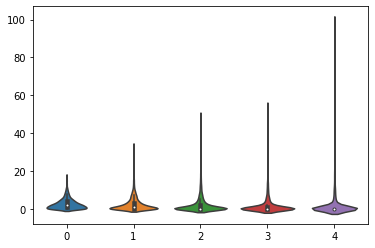

In [2072]:
sns.violinplot(pd.Series(x), y)

In [2073]:
def deconstruct_params(params):
    
    beta1 = params[:2]
    beta2 = params[2:4]
    p = params[-1]
    
    return beta1, beta2, p

In [2074]:
def moment_condition_loglinear(params):
    
    beta1_hat, beta2_hat, p_hat = deconstruct_params(params)
    
    # 1st moment
    residual1 = y.reshape(-1, 1) - np.exp(x_mat@beta1_hat.reshape(2, -1))
    residual_mat_1 = np.tile(residual1, (1, 2))
    error_1 = (x_mat*residual_mat_1).mean(axis=0)
    
    # Variance
    residual2 = (residual1**2) - (np.exp(x_mat@beta1_hat.reshape(2, -1))**p_hat*np.exp(x_mat@beta2_hat.reshape(2, -1)))
    residual_mat_2 = np.tile(residual2, (1, 2))
    error_2 = (x_mat*residual_mat_2).mean(axis=0)
    
    # Orthongality 
    error_3 = beta1_hat.reshape(2, -1).T@beta2_hat.reshape(2, -1).reshape(-1, 1)

    error = np.concatenate([error_1, error_2])
    error = np.append(error, error_3)
    return error
    

In [2075]:
class MeanGMM(GMM):

    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 2)
        kwds.setdefault('k_params', 2)
        super(MeanGMM, self).__init__(*args, **kwds)


    def momcond(self, params):
        
        y = self.endog
        x_mat = self.exog

        beta1_hat, beta2_hat, p_hat = deconstruct_params(params)

        # 1st moment
        residual1 = y.reshape(-1, 1) - np.exp(x_mat@beta1_hat.reshape(2, -1))
        residual_mat_1 = np.tile(residual1, (1, 2))
        error_1 = x_mat*residual_mat_1

        # Variance
        residual2 = (residual1**2) - (np.exp(x_mat@beta1_hat.reshape(2, -1))**p_hat*np.exp(x_mat@beta2_hat.reshape(2, -1)))
        residual_mat_2 = np.tile(residual2, (1, 2))
        error_2 = x_mat*residual_mat_2

        # Orthongality 
        error_3 = beta1_hat.reshape(2, -1).T@beta2_hat.reshape(2, -1).reshape(-1, 1)

        error = np.concatenate([error_1, error_2])
        error = np.hstack([error_1, error_2, np.ones((x_mat.shape[0], 1))*error_3])
        return error

In [2085]:
class MeanGMM(GMM):

    
    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 2)
        kwds.setdefault('k_params', 2)
        super(MeanGMM, self).__init__(*args, **kwds)


    def momcond(self, params):
                
        y = self.endog
        x_mat = self.exog

        beta1_hat = params

        # 1st moment
        residual1 = y.reshape(-1, 1) - np.exp(x_mat@beta1_hat.reshape(2, -1))
        residual_mat_1 = np.tile(residual1, (1, 2))
        error_1 = x_mat*residual_mat_1

        return error_1

In [2086]:
%%time
mean_init = np.ones(2)*(np.log(y+1).mean()/4)
mean_model = MeanGMM(y, x_mat, instrument=None)
mean_res = mean_model.fit(mean_init, maxiter=2, optim_method='nm', wargs=dict(centered=False))
print(mean_res.summary())

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 47
         Function evaluations: 89
Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 20
         Function evaluations: 40
                               MeanGMM Results                                
Dep. Variable:                      y   Hansen J:                    2.753e-06
Model:                        MeanGMM   Prob (Hansen J):                   nan
Method:                           GMM                                         
Date:                Mon, 02 Sep 2019                                         
Time:                        21:06:54                                         
No. Observations:               10000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        

In [2087]:
class VarGMM(GMM):

    def __init__(self, mean_coef=np.array([1, 1]), *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 3)
        kwds.setdefault('k_params', 3)
        self.mean_coef = mean_coef
        super(VarGMM, self).__init__(*args, **kwds)
        
        
    def momcond(self, params):
                
        y = self.endog
        x_mat = self.exog
        
        beta1_hat = self.mean_coef
        beta2_hat, p_hat = params[:2], params[-1]

        # 1st moment
        residual1 = y.reshape(-1, 1) - np.exp(x_mat@beta1_hat.reshape(2, -1))
        residual2 = (residual1**2) - (np.exp(x_mat@beta1_hat.reshape(2, -1))**p_hat*np.exp(x_mat@beta2_hat.reshape(2, -1)))
        residual_mat_2 = np.tile(residual2, (1, 2))
        error_2 = x_mat*residual_mat_2
        
        # Orthgonality
        error_3 = beta1_hat.reshape(2, -1).T@beta2_hat.reshape(2, -1).reshape(-1, 1)

        error = np.hstack([error_2, np.ones((x_mat.shape[0], 1))*error_3])
        #print(params)
        return error

In [2088]:
%%time
var_init = np.ones(2)/2
var_init = np.append(var_init, 1)
var_model = VarGMM(mean_coef=mean_res.params, endog=y, exog=x_mat, instrument=None)
var_res = var_model.fit(var_init, maxiter=2, optim_method='nm', wargs=dict(centered=False))
print(var_res.summary())

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 115
         Function evaluations: 203
Optimization terminated successfully.
         Current function value: 0.000214
         Iterations: 35
         Function evaluations: 72
                                VarGMM Results                                
Dep. Variable:                      y   Hansen J:                        2.144
Model:                         VarGMM   Prob (Hansen J):                   nan
Method:                           GMM                                         
Date:                Mon, 02 Sep 2019                                         
Time:                        21:06:55                                         
No. Observations:               10000                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
p 0        

In [2089]:
var_res.__dict__['_cache']['pvalues']

array([6.46776213e-08, 6.46833083e-08, 0.00000000e+00])

In [2090]:
mean_res.__dict__['_cache']['pvalues']

array([0.00000000e+00, 5.86042701e-25])

In [2091]:
%%time
init = np.ones(4)*(np.log(y+1).mean()/4)
init = np.append(init, 1)
print(init.shape)
#init = np.concatenate([beta1, beta2])
# result_1 = sp.optimize.fsolve(
#     moment_condition_loglinear, 
#     init)
result_2 = sp.optimize.fsolve(
    moment_condition_loglinear, 
    init)
print(result_2)

(5,)
[ 0.97436485 -0.08448097  0.00742134  0.08559434  2.13374766]
CPU times: user 83.3 ms, sys: 1.87 ms, total: 85.1 ms
Wall time: 82.5 ms


### Simulate some data with varying dispersion and a nonlinear component

In [1664]:
def convert_params(mu, theta):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    r = theta
    var = mu + 1 / r * mu ** 2
    p = (var - mu) / var
    return r, 1 - p

In [1741]:
num_rep = 1000
x = np.arange(0, 5, 1)
x = np.tile(x, (1, num_rep)).reshape(-1)
x_mat = np.column_stack([np.ones(x.shape[0]), x])
beta1 = np.array([2, 1])
beta2 = np.array([1, -0.1])
p = 1.4
beta_var = beta1*p + beta2
beta2_prime = beta_var - np.dot(beta_var, beta1)/np.linalg.norm(beta1)**2*beta1
mean = np.exp(x_mat@beta1)
alpha = np.exp(x_mat@beta2)
var = alpha * (mean**p)
#np.dot(x, y) / np.linalg.norm(y)
y = stats.nbinom.rvs(*convert_params(mean, 1/((var-mean)/mean**2)))
y = y.reshape(-1)

In [1742]:
np.dot(beta2_prime, beta1)

2.6645352591003757e-15

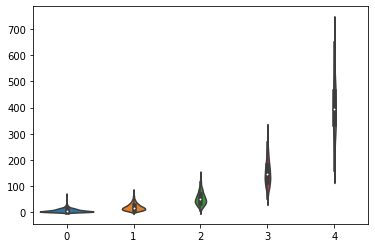

In [1743]:
sns.violinplot(pd.Series(x), y)

In [1744]:
def deconstruct_params(params):
    
    beta1 = params[:2]
    beta2 = params[2:4]
    p = params[-1]
    
    return beta1, beta2, p

In [1745]:
def moment_condition_loglinear(params):
    
    beta1_hat, beta2_hat, p_hat = deconstruct_params(params)
    
    # 1st moment
    residual1 = y.reshape(-1, 1) - np.exp(x_mat@beta1_hat.reshape(2, -1))
    residual_mat_1 = np.tile(residual1, (1, 2))
    error_1 = (x_mat*residual_mat_1).mean(axis=0)
    
    # Variance
    residual2 = (residual1**2) - (np.exp(x_mat@beta1_hat.reshape(2, -1))**p_hat*np.exp(x_mat@beta2_hat.reshape(2, -1)))
    residual_mat_2 = np.tile(residual2, (1, 2))
    error_2 = (x_mat*residual_mat_2).mean(axis=0)
    
    # Orthongality 
    error_3 = beta1_hat.reshape(2, -1).T@beta2_hat.reshape(2, -1).reshape(-1, 1)

    error = np.concatenate([error_1, error_2])
    error = np.append(error, error_3)
    return error
    

In [1746]:
%%time
init = np.ones(4)*(np.log(y+1).mean()/4)
init = np.append(init, 1)
print(init.shape)
#init = np.concatenate([beta1, beta2])
# result_1 = sp.optimize.fsolve(
#     moment_condition_loglinear, 
#     init)
result_2 = sp.optimize.fsolve(
    moment_condition_loglinear, 
    init)
print(result_2)

(5,)
[ 2.0017999   0.99935663  0.21600501 -0.43267719  1.7576313 ]
CPU times: user 209 ms, sys: 257 µs, total: 209 ms
Wall time: 206 ms


In [1747]:
print(beta1, deconstruct_params(result_2)[0])

[2 1] [2.0017999  0.99935663]


In [1748]:
print(beta2_prime, deconstruct_params(result_2)[1])

[ 0.24 -0.48] [ 0.21600501 -0.43267719]


In [1749]:
np.linalg.norm(moment_condition_loglinear(result_2))

2.3330515534561858e-07

### Dropout

In [1093]:
p = 0.1
noise_level = 0.2049755522580501
p_sq = (noise_level+1)*p**2
m = p
v = p_sq - p**2
alpha = m*(m*(1-m)/v - 1)
beta = (1-m)*(m*(1-m)/v - 1)

In [1094]:
num_rep = 3000
x = np.arange(0, 4, 1)
x = np.tile(x, (1, num_rep)).reshape(-1)
x_mat = np.column_stack([np.ones(x.shape[0]), x])
beta1 = np.array([1, 0.8])
beta2 = np.array([0.1, 0.0])
mean = np.exp(x_mat@beta1)
var = np.exp(x_mat@beta2) * mean
#y = stats.poisson.rvs(mean, size=(num_rep, x.shape[0]))
y = stats.nbinom.rvs(*convert_params(mean, 1/((var-mean)/mean**2)))
qs = stats.beta.rvs(alpha, beta, size=y.shape)
y_obs = stats.binom.rvs(y, qs)
y = y.reshape(-1)
y_obs = y_obs.reshape(-1)

In [1340]:
var

array([   54.59815003,   221.4064162 ,   897.84729165, ...,
         897.84729165,  3640.95030733, 14764.78156558])

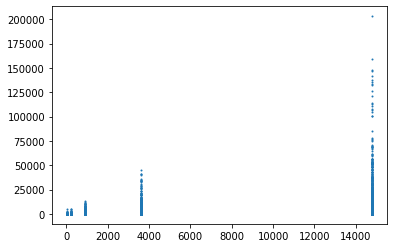

In [1345]:
plt.scatter(var, var_hat, s=1)

In [1346]:
var

array([   54.59815003,   221.4064162 ,   897.84729165, ...,
         897.84729165,  3640.95030733, 14764.78156558])

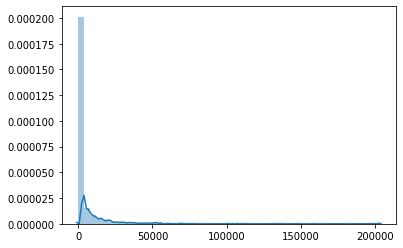

In [1342]:
#sns.distplot(var)
sns.distplot(var_hat)

In [1331]:
mean

array([  7.3890561 ,  20.08553692,  54.59815003, ...,  54.59815003,
       148.4131591 , 403.42879349])

In [1327]:
var_hat

array([[1.51364648e-01],
       [4.34946426e+00],
       [1.84909684e+02],
       ...,
       [8.76050485e+02],
       [1.71504975e+03],
       [3.55054102e+04]])

In [1328]:
var

array([   54.59815003,   221.4064162 ,   897.84729165, ...,
         897.84729165,  3640.95030733, 14764.78156558])

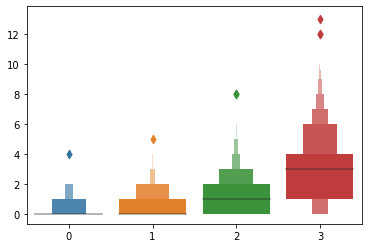

In [1095]:
sns.boxenplot(pd.Series(x), y_obs)

In [1398]:
var_hat = df.groupby(['x1', 'x2']).res_sq.mean().values

In [1317]:
k = (a-b)/c

In [1401]:
var_hat

array([   51.0134842 ,   223.8702392 ,   930.46683712,  3534.51917406,
       15329.03398648])

In [1402]:
mean_hat

array([  7.3890561 ,  20.08553692,  54.59815003, 148.4131591 ,
       403.42879349])

In [1403]:
alpha_hat

array([1.8221188 , 2.01375271, 2.22554093, 2.45960311, 2.71828183])

In [ ]:
np.log()

In [1399]:
var_hat

array([   51.0134842 ,   223.8702392 ,   930.46683712,  3534.51917406,
       15329.03398648])

In [1400]:
np.unique(mean_hat)

array([  7.3890561 ,  20.08553692,  54.59815003, 148.4131591 ,
       403.42879349])

In [1384]:
np.median(k)

1.2877175878588787

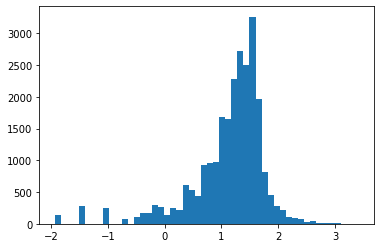

In [1383]:
plt.hist(k, bins=50);

In [1247]:
#print(result_1)
print(result_2)

[1.98325553 1.00275865 2.01819408 0.3862617 ]


In [1381]:
k = ((np.log(var_hat.reshape(-1, 1)) - np.log(alpha_hat))/np.log(mean_hat))

In [1318]:
k.mean()

0.6475709147044905

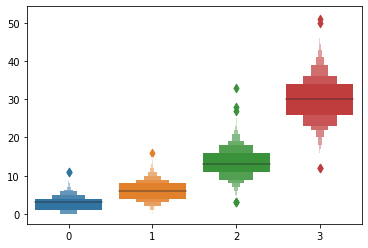

In [712]:
sns.boxenplot(pd.Series(x), y)

In [713]:
def moment_condition_loglinear(beta_hat):
    
    beta1_hat, beta2_hat = beta_hat[:int(beta_hat.shape[0]/2)], beta_hat[int(beta_hat.shape[0]/2):]
    
    residual1 = y_obs.reshape(-1, 1)/p - np.exp(x_mat@beta1_hat.reshape(2, -1))
    residual_mat_1 = np.tile(residual1, (1, 2))
    error_1 = (x_mat*residual_mat_1).mean(axis=0)
    
    residual2 = (residual1**2) - (np.exp(x_mat@(beta1_hat + beta2_hat).reshape(2, -1)))
    residual_mat_2 = np.tile(residual2, (1, 2))
    error_2 = (x_mat*residual_mat_2).mean(axis=0)
    
    return np.concatenate([error_1, error_2])
    #return (error_1**2).sum()# + (error_2**2).sum()
    

In [767]:
%%time
init = np.ones(4)*(np.log(y+1).mean()/4) #np.concatenate([beta1, beta2])
init = np.concatenate([beta1, beta2])
result = sp.optimize.fsolve(
    moment_condition_loglinear, 
    init)

CPU times: user 43.3 ms, sys: 942 µs, total: 44.3 ms
Wall time: 43.3 ms


In [768]:
result

array([ 2.0003989 ,  0.99989737,  1.11998413, -0.0111784 ])

### Simulate some data

In [421]:
def convert_params(mu, theta):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    r = theta
    var = mu + 1 / r * mu ** 2
    p = (var - mu) / var
    return r, 1 - p



In [422]:
data = pd.DataFrame()
data['x'] = x
data['y'] = y

In [435]:
beta1 = 0.3
beta2 = 2
x = np.arange(1, 10, 1)
means = np.exp(beta1*x)
thetas = np.exp(beta2*x)
y = stats.nbinom.rvs(*convert_params(means, thetas), size=(50, x.shape[0]))
x = np.tile(x, (1, 50)).reshape(-1)
y = y.reshape(-1)

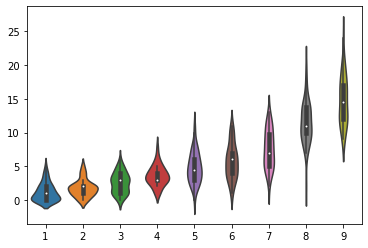

In [436]:
sns.violinplot(
pd.Series(x),
y.reshape(-1))

### Sample

In [1758]:
class GMMGamma(GMM):

    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 4)
        kwds.setdefault('k_params', 2)
        super(GMMGamma, self).__init__(*args, **kwds)


    def momcond(self, params):

        p0, p1 = params
        endog = self.endog
        error1 = endog - p0 / p1
        error2 = endog**2 - (p0 + 1) * p0 / p1**2
        error3 = 1 / endog - p1 / (p0 - 1)
        error4 = np.log(endog) + np.log(p1) - psi(p0)
        g = np.column_stack((error1, error2, error3, error4))
        print(g.shape)
        return g

In [1759]:
y = np.array([20.5, 31.5, 47.7, 26.2, 44.0, 8.28, 30.8, 17.2, 19.9, 9.96, 55.8, 25.2, 29.0, 85.5, 15.1, 28.5, 21.4, 17.7, 6.42, 84.9])

In [1760]:
nobs = y.shape[0]
x = np.ones((nobs, 4))

model = GMMGamma(y, x, None)
beta0 = np.array([2, 0.1])
res = model.fit(beta0, maxiter=2, optim_method='nm', wargs=dict(centered=False))
print(res.summary())

(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
(20, 4)
Optimiza

### Set up the GMM as if the latent variables were observed

In [453]:
class gmm(GMM):

    def __init__(self, *args, **kwds):
        # set appropriate counts for moment conditions and parameters
        # TODO: clean up signature
        kwds.setdefault('k_moms', 1)
        kwds.setdefault('k_params', 1)
        super(gmm, self).__init__(*args, **kwds)

    def momcond(self, params):
        
        params = params[0]
        return (self.exog*(self.endog - params*self.exog))


In [454]:
y.shape

(450,)

In [455]:
x.shape

(450,)

In [456]:
model = gmm(y, x, None)
beta0 = 0.5
res = model.fit(beta0, maxiter=2, optim_method='nm', wargs=dict(centered=False))

ValueError: shapes (450,) and (1,1) not aligned: 450 (dim 0) != 1 (dim 0)

### Binomial beta case

In [4]:
p = 0.1

In [35]:
distances = []
Ns = np.arange(5, 5000, 1)

for N in Ns:
    
    binom_x = np.arange(0, N, 1)
    binom_y = stats.binom.pmf(np.arange(0, N, 1), N, p)
    binom_x = binom_x / N
    binom_y = binom_y * N
    
    beta_x = binom_x
    beta_y = stats.beta.pdf(beta_x, N*p, N*(1-p))
    
    
    
    distances.append(((binom_y - beta_y)**2).mean())

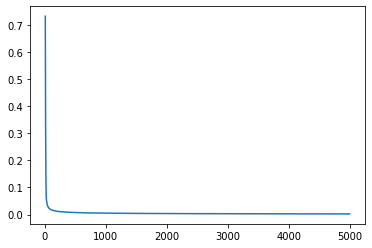

In [36]:
plt.plot(Ns, distances)

In [37]:
distances[-1:]

[0.002242356154609695]

In [77]:
N = 1000
p = 0.5

In [78]:
binom_x = np.arange(0, N, 1)
binom_y = stats.binom.pmf(np.arange(0, N, 1), N, p)
binom_x = binom_x / N
binom_y = binom_y * N

In [100]:
p = 0.1
noise_level = 0.2049755522580501
p_sq = (noise_level+1)*p**2

In [101]:
m = p
v = p_sq - p**2

In [104]:
alpha = m*(m*(1-m)/v - 1)
beta = (1-m)*(m*(1-m)/v - 1)

In [105]:
qs = stats.beta.rvs(alpha, beta, size=10000)

In [106]:
qs.var()

0.002001210874947601

(0, 1)

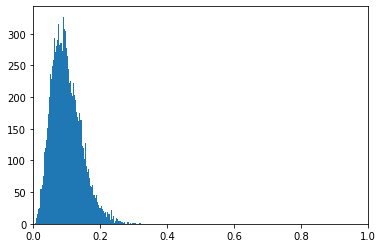

In [107]:
plt.hist(qs, bins=100);
plt.xlim(0, 1)

(0, 1)

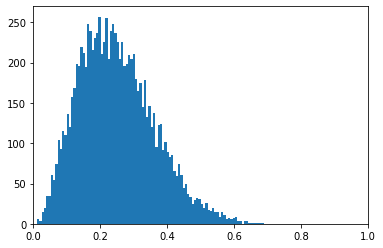

In [76]:
plt.hist(qs, bins=100);
plt.xlim(0, 1)

1000


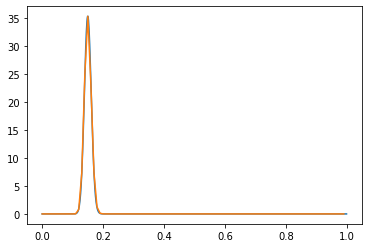

In [31]:
plt.plot(binom_x, binom_y)
print(N)


plt.plot(np.arange(0, 1, 0.01), stats.beta.pdf(np.arange(0, 1, 0.01), N*p, N*(1-p)))

25


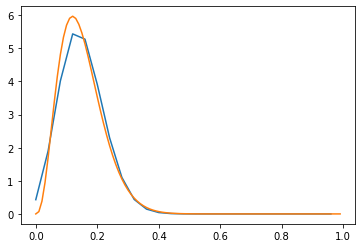

In [28]:
plt.plot(binom_x, binom_y)
print(N)
plt.plot(np.arange(0, 1, 0.01), stats.beta.pdf(np.arange(0, 1, 0.01), N*p, N*(1-p)))

10


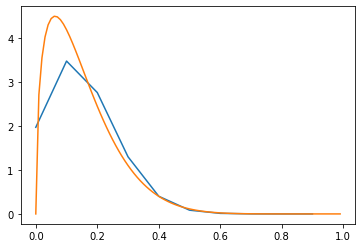

In [20]:
plt.plot(binom_x, binom_y)
print(N)
plt.plot(np.arange(0, 1, 0.01), stats.beta.pdf(np.arange(0, 1, 0.01), N*p, N*(1-p)))

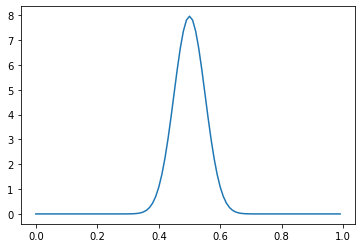

In [14]:
plt.plot(np.arange(0, 1, 0.01), stats.beta.pdf(np.arange(0, 1, 0.01), N*p, N*(1-p)))

### Computing ASL

In [63]:
a = stats.norm.rvs(loc=-3.5, size=5000)
b = stats.norm.rvs(loc=3.5, size=5000)

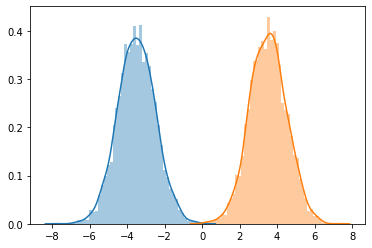

In [64]:
sns.distplot(a)
sns.distplot(b)

In [65]:
import itertools

In [66]:
sig = 0

In [70]:
%%time
(np.array([(x-y) for x,y in itertools.product(a,b)]) > 0).sum()

CPU times: user 5.67 s, sys: 949 ms, total: 6.62 s
Wall time: 6.61 s


4

In [71]:
%%time
sig = 0
for x, y in itertools.product(a,b):
    
    if x > y:
        sig += 1
print(sig)

4
CPU times: user 3.66 s, sys: 13.2 ms, total: 3.68 s
Wall time: 3.69 s


In [51]:
np.array([(x-y) for x,y in itertools.product(a,b)]) > 0)

KeyboardInterrupt: 

In [12]:
# Assign the condition
condition_cov = np.random.randint(2, size=10)

# Assign the batch
batch_cov = np.random.choice(['batch-' + str(i) for i in range(1, 3)], size=10)

# Create the design matrix
df = pd.DataFrame()
df['condition'] = condition_cov
df['batch'] = batch_cov

In [15]:
pd.get_dummies(df).values

array([[0, 0, 1],
       [1, 0, 1],
       [0, 1, 0],
       [1, 0, 1],
       [0, 0, 1],
       [1, 1, 0],
       [1, 1, 0],
       [0, 0, 1],
       [1, 0, 1],
       [0, 0, 1]])

In [13]:
df

,condition,batch
0,0,batch-2
1,1,batch-2
2,0,batch-1
3,1,batch-2
4,0,batch-2
5,1,batch-1
6,1,batch-1
7,0,batch-2
8,1,batch-2
9,0,batch-2


In [11]:
np.random.choice(['a', 'b', 'c'], size=10)

array(['c', 'c', 'a', 'b', 'a', 'b', 'b', 'c', 'b', 'b'], dtype='<U1')